In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import time
import random
import sys
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


# n = 20
# steps = [(np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)for i in range(50)]
# anim = animate(steps);
# HTML(anim.to_html5_video())

# **Zadatak 1**

---



#### Primer pod a)



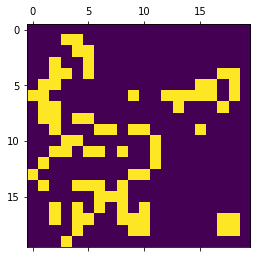

In [ ]:
from os import read

n = 20
steps_init = 10
state = np.random.randint(2, size=(n,n)) 
seq = [state]

move_i = [0,0,-1,-1,-1, 1, 1, 1]
move_j = [-1,1,-1, 0, 1,-1,0,1]

N = n**2
mutex_in = threading.Lock()
mutex_out = threading.Lock()
mutex = threading.Lock()
waitroom_in = 0
waitroom_out = N
done_iteration = True
counter_read = np.zeros(N).reshape(n,n)
# count_read_lock = [[threading.Lock() for _ in range(n)] for _ in range(n)]
count_read_lock = np.array([threading.Lock() for _ in range(N)]).reshape(n,n)



def cell(steps=5, i=0, j=0):
  global n, state, seq, done_iteration, N, waitroom_in, waitroom_out, counter_read, counter_read_lock, prom, move_i, move_j
  for step in range(steps):
# inicijalno
    while(1):
      mutex_out.acquire()
      if(waitroom_out == N):
        mutex_out.release()
        break
      mutex_out.release()
      time.sleep(0.001)

    mutex_in.acquire()
    if(waitroom_in == 0):
      mutex.acquire()
      done_iteration = False
      mutex.release()
    waitroom_in += 1
    mutex_in.release()

# # # ##############################################################
    alive = 0
    for k in range(len(move_i)):
      ii = i + move_i[k]
      jj = j + move_j[k]
      if ii >= 0 and ii < n and jj >= 0 and jj < n:
        if(state[ii][jj]==1):
          count_read_lock[ii][jj].acquire()
          counter_read[ii][jj] += 1
          alive += 1
          count_read_lock[ii][jj].release()
        else:
          count_read_lock[ii][jj].acquire()
          counter_read[ii][jj] += 1
          count_read_lock[ii][jj].release()


    while(1):
      if((i == 0 and j == 0) or (i == 0 and j == n-1) or (i == n-1 and j == 0) or (i == n-1 and j == n-1)):
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 3):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      elif((i == 0 and (j > 0 and j < n-1)) or (i == n-1 and (j > 0 and j < n-1)) or (j == 0 and (i > 0 and i < n-1)) or (j == n-1 and (i > 0 and i < n-1))):
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 5):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      else:
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 8):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      time.sleep(0.01)

    # sys.stdout.write(f'Working thread: {threading.current_thread().name}, {step}\n')
    if state[i][j] == 0 and alive == 3:
      state[i][j] = 1
    if state[i][j] == 1 and (alive < 2 or alive > 3):
      state[i][j] = 0
    
# # # ##############################################################
    mutex_in.acquire()
    mutex_out.acquire()
    mutex.acquire()
    if(waitroom_in == N):
      waitroom_in = 0
      waitroom_out = 0
      seq.append(list(map(list, state)))
      done_iteration = True
    mutex.release()
    mutex_out.release()
    mutex_in.release()


    while(1):
      mutex.acquire()
      if(done_iteration == True):
        mutex.release()
        break
      mutex.release()
      time.sleep(0.1)

    mutex_out.acquire()
    waitroom_out += 1
    mutex_out.release()
    time.sleep(0.01)



threads = [[threading.Thread(name=f'thread[{i}][{j}]',target=cell, args=(steps_init,i,j)) for j in range(n)] for i in range(n)]

threads = np.ndarray(shape=(n,n), dtype=threading.Thread)

for  i in range(n):
  for j in range(n):
    threads[i][j] = threading.Thread(name=f'thread[{i}][{j}]',target=cell, args=(steps_init,i,j))

for i in range(n):
  for j in range(n):
    threads[i][j].start()
# sys.stdout.write('Poceo')    

for i in range(n):
  for j in range(n):
    threads[i][j].join()



anim = animate(seq)
HTML(anim.to_html5_video())

Primer pod b)

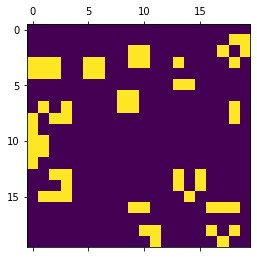

In [ ]:
from os import read

n = 20
steps_init = 10
state = np.random.randint(2, size=(n,n)) 
seq = [state]

move_i = [0,0,-1,-1,-1, 1, 1, 1]
move_j = [-1,1,-1, 0, 1,-1,0,1]

N = n**2
con = threading.Condition()
waitroom = 0
counter_read = np.zeros(N).reshape(n,n)
# count_read_lock = [[threading.Lock() for _ in range(n)] for _ in range(n)]
count_read_lock = np.array([threading.Lock() for _ in range(N)]).reshape(n,n)

def cell(steps=5, i=0, j=0):
  global n, state, seq, N, waitroom, counter_read, counter_read_lock, move_i, move_j
  for step in range(steps):
    # con.acquire()
    # waitroom += 1
    # con.release()

# # # ##############################################################
    alive = 0
    for k in range(len(move_i)):
      ii = i + move_i[k]
      jj = j + move_j[k]
      if ii >= 0 and ii < n and jj >= 0 and jj < n:
        if(state[ii][jj]==1):
          count_read_lock[ii][jj].acquire()
          counter_read[ii][jj] += 1
          alive += 1
          count_read_lock[ii][jj].release()
        else:
          count_read_lock[ii][jj].acquire()
          counter_read[ii][jj] += 1
          count_read_lock[ii][jj].release()


    while(1):
      if((i == 0 and j == 0) or (i == 0 and j == n-1) or (i == n-1 and j == 0) or (i == n-1 and j == n-1)):
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 3):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      elif((i == 0 and (j > 0 and j < n-1)) or (i == n-1 and (j > 0 and j < n-1)) or (j == 0 and (i > 0 and i < n-1)) or (j == n-1 and (i > 0 and i < n-1))):
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 5):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      else:
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 8):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      time.sleep(0.01)

    # sys.stdout.write(f'Working thread: {threading.current_thread().name}, {step}\n')
    if state[i][j] == 0 and alive == 3:
      state[i][j] = 1
    if state[i][j] == 1 and (alive < 2 or alive > 3):
      state[i][j] = 0
    
# # # ##############################################################
  
    con.acquire()
    waitroom+=1
    if(waitroom == N):
      waitroom = 0
      seq.append(list(map(list, state)))
      con.notifyAll()
    else:
      con.wait()
    con.release()
    time.sleep(0.1)



threads = np.ndarray(shape=(n,n), dtype=threading.Thread)

for  i in range(n):
  for j in range(n):
    threads[i][j] = threading.Thread(name=f'thread[{i}][{j}]',target=cell, args=(steps_init,i,j))

for i in range(n):
  for j in range(n):
    threads[i][j].start()

for i in range(n):
  for j in range(n):
    threads[i][j].join()

anim = animate(seq)
HTML(anim.to_html5_video())

Primer pod c)

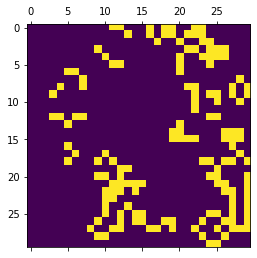

In [ ]:
n = 30
steps_init = 10
state = np.random.randint(2, size=(n,n)) 
seq = [state]

move_i = [0,0,-1,-1,-1, 1, 1, 1]
move_j = [-1,1,-1, 0, 1,-1,0,1]

N = n**2
bar = threading.Barrier(parties=N)
counter_read = np.zeros(N).reshape(n,n)
# count_read_lock = [[threading.Lock() for _ in range(n)] for _ in range(n)]
count_read_lock = np.array([threading.Lock() for _ in range(N)]).reshape(n,n)



def cell(steps=5, i=0, j=0):
  global n, state, seq, done_iteration, N, waitroom_in, waitroom_out, counter_read, counter_read_lock, prom, move_i, move_j
  for step in range(steps):
# # # ##############################################################
    alive = 0
    for k in range(len(move_i)):
      ii = i + move_i[k]
      jj = j + move_j[k]
      if ii >= 0 and ii < n and jj >= 0 and jj < n:
        if(state[ii][jj]==1):
          count_read_lock[ii][jj].acquire()
          counter_read[ii][jj] += 1
          alive += 1
          count_read_lock[ii][jj].release()
        else:
          count_read_lock[ii][jj].acquire()
          counter_read[ii][jj] += 1
          count_read_lock[ii][jj].release()


    while(1):
      if((i == 0 and j == 0) or (i == 0 and j == n-1) or (i == n-1 and j == 0) or (i == n-1 and j == n-1)):
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 3):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      elif((i == 0 and (j > 0 and j < n-1)) or (i == n-1 and (j > 0 and j < n-1)) or (j == 0 and (i > 0 and i < n-1)) or (j == n-1 and (i > 0 and i < n-1))):
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 5):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      else:
        count_read_lock[i][j].acquire()
        if(counter_read[i][j] == 8):
          counter_read[i][j] = 0
          count_read_lock[i][j].release()
          break
        count_read_lock[i][j].release()
      time.sleep(0.01)

    # sys.stdout.write(f'Working thread: {threading.current_thread().name}, {step}\n')
    if state[i][j] == 0 and alive == 3:
      state[i][j] = 1
    if state[i][j] == 1 and (alive < 2 or alive > 3):
      state[i][j] = 0
    
# # # ##############################################################
    bar.wait()
    if(i == 0 and j == 0):
      seq.append(list(map(list, state)))





# threads = [[threading.Thread(name=f'thread[{i}][{j}]',target=cell, args=(steps_init,i,j)) for j in range(n)] for i in range(n)]
threads = np.ndarray(shape=(n,n), dtype=threading.Thread)

for  i in range(n):
  for j in range(n):
    threads[i][j] = threading.Thread(name=f'thread[{i}][{j}]',target=cell, args=(steps_init,i,j))

for i in range(n):
  for j in range(n):
    threads[i][j].start()

for i in range(n):
  for j in range(n):
    threads[i][j].join()

anim = animate(seq)
HTML(anim.to_html5_video())

# **Zadatak 2**

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import time
import random
import sys
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


# n = 20
# steps = [(np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)for i in range(50)]
# anim = animate(steps);
# HTML(anim.to_html5_video())

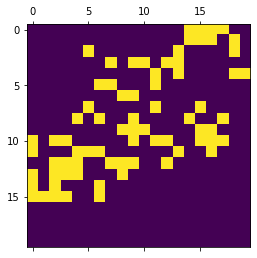

In [ ]:
import sys
import queue
import multiprocessing
from multiprocessing import Process
from multiprocessing import Queue
import numpy as np



n = 20
N = n**2
iterations = 10
mat_queue = np.array([Queue() for _ in range(N)]).reshape(n,n)
main_queue = Queue()
move_i = np.array([0,0,-1,-1,-1, 1, 1, 1])
move_j = np.array([-1,1,-1, 0, 1,-1,0,1])
message = Queue()

def cell(state, i, j, mat_queue, main_queue, move_i, move_j, n, iterations):

  for k in range(iterations):
    n_neighbours = 0
    for pom in range(len(move_i)):
      ii = i + move_i[pom]
      jj = j + move_j[pom]
      if ii >= 0 and ii < n and jj >= 0 and jj < n:
        mat_queue[ii][jj].put(state)
        n_neighbours += 1
    

    alive = 0
    for q in range(n_neighbours):
      alive += mat_queue[i][j].get()

   
    if state == 0 and alive == 3:
      state = 1
    if state == 1 and (alive < 2 or alive > 3):
      state = 0


    main_queue.put((state, i, j, k))

def reconstruct(main_queue, n, iterations, message):
  seq = []
  total = n**2 * iterations
  
  tensor = np.zeros(total).reshape(iterations, n,n)
  # print(tensor)
  for step in range(total):
    state, i, j, k = main_queue.get()
    # print(f'{step}\n')
    tensor[k][i][j] = state
  

  for k in range(iterations):
    # seq.append(list(map(list, tensor[k])))
    # print(tensor[k])
    message.put(list(map(list, tensor[k])))
  # print("Nesto")
  # message.put(seq)

  
processes = np.ndarray(shape=(n,n), dtype=Process)
seq=[]
for  i in range(n):
  for j in range(n):
    st = np.random.randint(2)
    processes[i][j] = Process(target=cell, args=(st, i, j, mat_queue, main_queue, move_i, move_j, n, iterations))
pro = Process(target=reconstruct, args=(main_queue, n, iterations, message))
pro.start()
for i in range(n):
  for j in range(n):
    processes[i][j].start()


for i in range(n):
  for j in range(n):
    processes[i][j].join()
for k in range(iterations):
  seq.append(message.get())
pro.join()


anim = animate(seq)
HTML(anim.to_html5_video())


# **Zadatak 3**

---

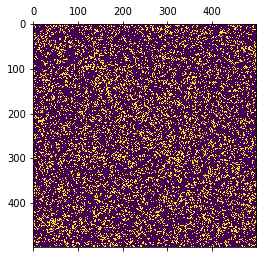

In [ ]:



import numpy as np
import matplotlib.pyplot as plt
import threading
import time
import random
import sys
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import multiprocessing as mp
import math

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


def pool_function(segment, size, mat, chunks, n, move_i, move_j):
  i = math.floor((segment * size)/n)
  j = math.floor((segment * size)%n)
  ret_state = []

  if segment==chunks-1:
    size=n*n-(chunks-1 * size)
  for k in range(size):
    alive = 0
    for pom in range(len(move_i)):
        ii = i + move_i[pom]
        jj = j + move_j[pom]
        if ii >= 0 and ii < n and jj >= 0 and jj < n and mat[ii][jj] == 1:
          alive += 1
    if mat[i][j] == 0 and alive == 3:
        ret_state.append((i,j,1))
    elif mat[i][j] == 1 and (alive < 2 or alive > 3):
        ret_state.append((i,j,0))
    else:
        ret_state.append((i,j,mat[i][j]))
    j+=1
    if j==n:
      j=0
      i+=1
    if i==n:
      break;
  return ret_state
        


move_i = np.array([0,0,-1,-1,-1, 1, 1, 1])
move_j = np.array([-1,1,-1, 0, 1,-1,0,1])
n = 500
N = n**2
iter = 10
pool = mp.Pool(mp.cpu_count())
chunks = 4
size = math.floor(N/chunks)
mat = np.random.randint(2, size=(n,n)) 
seq = [list(map(list, mat))]
for i in range(iter):
  tensor = pool.starmap(pool_function, [(k, size, mat, chunks, n, move_i, move_j) for k in range(chunks)])
  for t in tensor: 
    for k in t:
     ii, jj, alive = k
     mat[ii][jj] = alive
  seq.append(list(map(list, mat)))
  
anim = animate(seq)
HTML(anim.to_html5_video())